In [1]:
import torch
from torch import nn
import numpy as np
import mdshare 
import mdtraj as md 
import glob
import torch.nn.functional as F
from ase import Atoms
from nglview import show_ase
import nglview as ng
import matplotlib.pyplot as plt

In [2]:
# define a CGAE

class cgae(nn.Module):
    
    def __init__(self, n_atoms, n_cgs):
        super().__init__()

        assign_map = torch.randn(n_atoms, n_cgs)
        decode = torch.randn(n_cgs, n_atoms)
        
        
        self.n_atoms = n_atoms 
        self.assign_map = nn.Parameter(assign_map)
        self.decode = nn.Parameter(decode)
        
    def forward(self, xyz, tau=1.0):
        
        # recenter coordinates 
        xyz = xyz.reshape(-1, self.n_atoms, 3)
        shift = xyz.mean(1)
        xyz = xyz - shift.unsqueeze(1)
        
        # get discrete assignment map
        M = F.gumbel_softmax(self.assign_map, dim=-1)
        M_norm = M / M.sum(-2).unsqueeze(-2)
        
        cg_xyz = torch.einsum('bij,in->bnj', xyz, M_norm)
        xyz_recon = torch.einsum('bnj,ni->bij', cg_xyz, self.decode)
        
        return xyz, xyz_recon, M, M_norm, cg_xyz

In [3]:
ae_L6 = torch.load('LANGEVIN/Models/ae_CG6.pth').to('cpu')
ae_L6.eval()

ae_NH6 = torch.load('NOSE_HOOVER/Models/ae_CG6.pth').to('cpu')
ae_NH6.eval()

ae_NH62 = torch.load('NOSE_HOOVER_2/Models/ae_CG6.pth').to('cpu')
ae_NH62.eval()

ae_L24 = torch.load('LANGEVIN/Models/ae_CG24.pth').to('cpu')
ae_L24.eval()

ae_NH24 = torch.load('NOSE_HOOVER/Models/ae_CG24.pth').to('cpu')
ae_NH24.eval()

ae_NH224 = torch.load('NOSE_HOOVER_2/Models/ae_CG24.pth').to('cpu')
ae_NH224.eval()

cgae()

In [29]:
# build dataset and dataloader 
k = 10000
tau = 0.4

data_L = np.load('LANGEVIN/N_70.npy')
data_NH = np.load('NOSE_HOOVER/N_70.npy')
data_NH2 = np.load('NOSE_HOOVER_2/N_70.npy')


test_xyz_L  = torch.Tensor(data_L[k:])
test_xyz_NH  = torch.Tensor(data_NH[k:])
test_xyz_NH2  = torch.Tensor(data_NH2[k:])


In [30]:
xyz_L6, xyz_recon_L6, M_L6, M_norm_L6, cg_xyz_L6 = ae_L6(test_xyz_L[50], tau)
xyz_NH6, xyz_recon_NH6, M_NH6, M_norm_NH6, cg_xyz_NH6 = ae_NH6(test_xyz_NH[0], tau)
xyz_NH26, xyz_recon_NH26, M_NH26, M_norm_NH26, cg_xyz_NH26 = ae_NH6(test_xyz_NH2[0], tau)

xyz_L24, xyz_recon_L24, M_L24, M_norm_L24, cg_xyz_L24 = ae_L24(test_xyz_L[50], tau)
xyz_NH24, xyz_recon_NH24, M_NH24, M_norm_NH24, cg_xyz_NH24 = ae_NH24(test_xyz_NH[0], tau)
xyz_NH224, xyz_recon_NH224, M_NH224, M_norm_NH224, cg_xyz_NH224 = ae_NH224(test_xyz_NH2[0], tau)

In [21]:
xyz = xyz_L6.reshape(70, 3).detach().cpu().numpy()

In [31]:
N_70_original_L = Atoms(positions= xyz_L6.reshape(70, 3).detach().cpu().numpy(), numbers=[1]*70)
show_ase(N_70_original_L)

NGLWidget()

In [32]:
N_70_CGL6 = Atoms(positions= cg_xyz_L6.reshape(6, 3).detach().cpu().numpy(), numbers=[1]*6)
show_ase(N_70_CGL6)

NGLWidget()

In [33]:
N_70_CGL24 = Atoms(positions= cg_xyz_L24.reshape(24, 3).detach().cpu().numpy(), numbers=[1]*24)
show_ase(N_70_CGL24)

NGLWidget()

In [34]:
N_70_recon_L6 = Atoms(positions= xyz_recon_L6.reshape(70, 3).detach().cpu().numpy(), numbers=[1]*70)
show_ase(N_70_recon_L6)

NGLWidget()

In [35]:
N_70_recon_L24 = Atoms(positions= xyz_recon_L24.reshape(70, 3).detach().cpu().numpy(), numbers=[1]*70)
show_ase(N_70_recon_L24)

NGLWidget()

In [11]:
N_70_original_NH = Atoms(positions= xyz_NH6.reshape(70, 3).detach().cpu().numpy(), numbers=[1]*70)
show_ase(N_70_original_NH)

NGLWidget()

In [12]:
N_70_CGNH6 = Atoms(positions= cg_xyz_NH6.reshape(6, 3).detach().cpu().numpy(), numbers=[1]*6)
show_ase(N_70_CGNH6)

NGLWidget()

In [13]:
N_70_CGNH24 = Atoms(positions= cg_xyz_NH24.reshape(24, 3).detach().cpu().numpy(), numbers=[1]*24)
show_ase(N_70_CGNH24)

NGLWidget()

In [14]:
N_70_recon_NH6 = Atoms(positions= xyz_recon_NH6.reshape(70, 3).detach().cpu().numpy(), numbers=[1]*70)
show_ase(N_70_recon_NH6)

NGLWidget()

In [15]:
N_70_recon_NH24 = Atoms(positions= xyz_recon_NH24.reshape(70, 3).detach().cpu().numpy(), numbers=[1]*70)
show_ase(N_70_recon_NH24)

NGLWidget()

In [16]:
N_70_original_NH2 = Atoms(positions= xyz_NH26.reshape(70, 3).detach().cpu().numpy(), numbers=[1]*70)
show_ase(N_70_original_NH2)

NGLWidget()

In [17]:
N_70_CGNH26 = Atoms(positions= cg_xyz_NH26.reshape(6, 3).detach().cpu().numpy(), numbers=[1]*6)
show_ase(N_70_CGNH26)

NGLWidget()

In [18]:
N_70_CGNH224 = Atoms(positions= cg_xyz_NH224.reshape(24, 3).detach().cpu().numpy(), numbers=[1]*24)
show_ase(N_70_CGNH224)

NGLWidget()

In [19]:
N_70_recon_NH26 = Atoms(positions= xyz_recon_NH26.reshape(70, 3).detach().cpu().numpy(), numbers=[1]*70)
show_ase(N_70_recon_NH26)

NGLWidget()

In [20]:
N_70_recon_NH224 = Atoms(positions= xyz_recon_NH224.reshape(70, 3).detach().cpu().numpy(), numbers=[1]*70)
show_ase(N_70_recon_NH224)

NGLWidget()

In [16]:
N_70_original_L.write('pr_or_L.png',  rotation='')

In [2]:
#Loss data import
loss_ae_CG6n  = np.loadtxt('NOSE_HOOVER/Losses/loss_ae_CG6.txt')
loss_ae_CG12n  = np.loadtxt('NOSE_HOOVER/Losses/loss_ae_CG12.txt')
loss_ae_CG18n  = np.loadtxt('NOSE_HOOVER/Losses/loss_ae_CG18.txt')
loss_ae_CG24n  = np.loadtxt('NOSE_HOOVER/Losses/loss_ae_CG24.txt')

loss_ae_CG6n2  = np.loadtxt('NOSE_HOOVER_2/Losses/loss_ae_CG6.txt')
loss_ae_CG12n2  = np.loadtxt('NOSE_HOOVER_2/Losses/loss_ae_CG12.txt')
loss_ae_CG18n2  = np.loadtxt('NOSE_HOOVER_2/Losses/loss_ae_CG18.txt')
loss_ae_CG24n2  = np.loadtxt('NOSE_HOOVER_2/Losses/loss_ae_CG24.txt')

loss_fm_CG6n2  = np.loadtxt('NOSE_HOOVER_2/Losses/loss_fm_CG6.txt')
loss_fm_CG12n2  = np.loadtxt('NOSE_HOOVER_2/Losses/loss_fm_CG12.txt')
loss_fm_CG18n2  = np.loadtxt('NOSE_HOOVER_2/Losses/loss_fm_CG18.txt')
loss_fm_CG24n2  = np.loadtxt('NOSE_HOOVER_2/Losses/loss_fm_CG24.txt')

loss_log_CG6n2  = np.loadtxt('NOSE_HOOVER_2/Losses/loss_log_CG6.txt')
loss_log_CG12n2  = np.loadtxt('NOSE_HOOVER_2/Losses/loss_log_CG12.txt')
loss_log_CG18n2  = np.loadtxt('NOSE_HOOVER_2/Losses/loss_log_CG18.txt')
loss_log_CG24n2  = np.loadtxt('NOSE_HOOVER_2/Losses/loss_log_CG24.txt')


loss_ae_CG6l  = np.loadtxt('LANGEVIN/Losses/loss_ae_CG6.txt')
loss_ae_CG12l  = np.loadtxt('LANGEVIN/Losses/loss_ae_CG12.txt')
loss_ae_CG18l  = np.loadtxt('LANGEVIN/Losses/loss_ae_CG18.txt')
loss_ae_CG24l  = np.loadtxt('LANGEVIN/Losses/loss_ae_CG24.txt')

loss_fm_CG6l  = np.loadtxt('LANGEVIN/Losses/loss_fm_CG6.txt')
loss_fm_CG12l  = np.loadtxt('LANGEVIN/Losses/loss_fm_CG12.txt')
loss_fm_CG18l  = np.loadtxt('LANGEVIN/Losses/loss_fm_CG18.txt')
loss_fm_CG24l  = np.loadtxt('LANGEVIN/Losses/loss_fm_CG24.txt')

loss_log_CG6l  = np.loadtxt('LANGEVIN/Losses/loss_log_CG6.txt')
loss_log_CG12l  = np.loadtxt('LANGEVIN/Losses/loss_log_CG12.txt')
loss_log_CG18l  = np.loadtxt('LANGEVIN/Losses/loss_log_CG18.txt')
loss_log_CG24l  = np.loadtxt('LANGEVIN/Losses/loss_log_CG24.txt')

RHO_L = [1*10**(-5), 7*10**(-6), 1*10**(-6), 7*10**(-7)]
RHO_NH = [ 1*10**(-5), 1*10**(-6), 5*10**(-7), 1*10**(-7)]
N_CG = [6, 12, 18, 24]

In [3]:
loss_ae_CGn2 = np.array([loss_ae_CG6n2[-1], loss_ae_CG12n2[-1], loss_ae_CG18n2[-1], loss_ae_CG24n2[-1]])
loss_fm_CGn2 = np.array([loss_fm_CG6n2[-1], loss_fm_CG12n2[-1], loss_fm_CG18n2[-1], loss_fm_CG24n2[-1]])
loss_log_CGn2 = np.array([loss_log_CG6n2[-1], loss_log_CG12n2[-1], loss_log_CG18n2[-1], loss_log_CG24n2[-1]])

loss_ae_CGn = np.array([loss_ae_CG6n[-1], loss_ae_CG12n[-1], loss_ae_CG18n[-1], loss_ae_CG24n[-1]])


loss_ae_CGl = np.array([loss_ae_CG6l[-1], loss_ae_CG12l[-1], loss_ae_CG18l[-1], loss_ae_CG24l[-1]])
loss_fm_CGl = np.array([loss_fm_CG6l[-1], loss_fm_CG12l[-1], loss_fm_CG18l[-1], loss_fm_CG24l[-1]])
loss_log_CGl = np.array([loss_log_CG6l[-1], loss_log_CG12l[-1], loss_log_CG18l[-1], loss_log_CG24l[-1]])

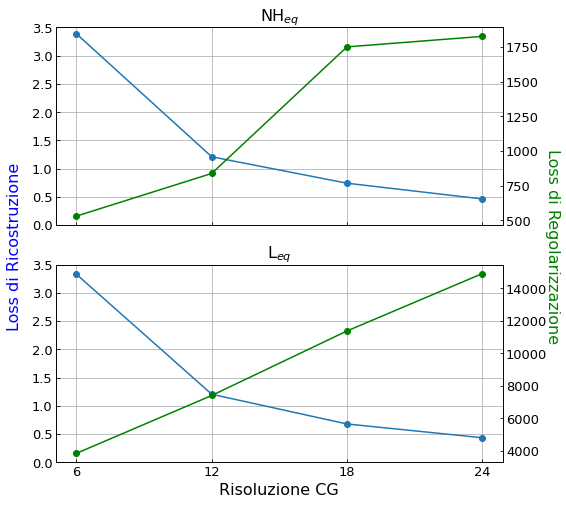

In [18]:
#plot losses
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8,8))
fig.text(0.04, 0.5, 'Loss di Ricostruzione', va='center', rotation= 90, fontsize=16, color = 'blue')
fig.text(0.973, 0.5, 'Loss di Regolarizzazione', va='center', rotation=-90, fontsize=16, color = 'green')

axes[0].set_title(r'NH$_{eq}$', fontsize=16)
axes[0].plot(N_CG, loss_ae_CGn2, 'o-', label = 'Loss_ae')
#ax1.set_ylabel('Reconstruction loss')
axes[0].set_xticks(ticks=[6,  12,  18,  24])
axes[0].tick_params(axis='x', direction='in')
axes[0].tick_params(axis='y', direction='in', labelsize=13)
axes[0].grid()
axes[0].set_ylim(0, 3.5)
#axes[0].legend(loc='center left')

axes0 = axes[0].twinx()
axes0.plot(N_CG, loss_fm_CGn2/RHO_NH, 'o-', label = 'Loss_fm', color = 'green')
#ax1.set_ylabel('Reconstruction loss')
#axes0.set_xticks(ticks=[6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26])
axes0.tick_params(axis='x', direction='in', labelsize=10)
axes0.tick_params(axis='y', direction='in', labelsize=13)
#axes0.grid()
#axes0.legend(loc='center right')




axes[1].set_title(r'L$_{eq}$', fontsize=16)
axes[1].plot(N_CG, loss_ae_CGl, 'o-', label = r'$Loss_{ae}$')
#ax1.set_ylabel('Reconstruction loss')
axes[1].set_xticks(ticks=[6,  12,  18,  24])
axes[1].tick_params(axis='x', direction='in', labelsize=13)
axes[1].tick_params(axis='y', direction='in', labelsize=13)
axes[1].set_xlabel('Risoluzione CG', fontsize=16)
axes[1].grid()
axes[1].set_ylim(0, 3.5)
#axes[1].legend(loc='center left')

axes1 = axes[1].twinx()
axes1.plot(N_CG, loss_fm_CGl/RHO_L, 'o-', label = 'Loss_fm', color = 'green')
#ax1.set_ylabel('Reconstruction loss')
#axes0.set_xticks(ticks=[6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26])
axes1.tick_params(axis='x', direction='in', labelsize=13)
axes1.tick_params(axis='y', direction='in', labelsize=13)
#axes0.grid()
#axes1.legend(loc='center right')
plt.savefig('LvsNH2.png', dpi=1200)
plt.show()

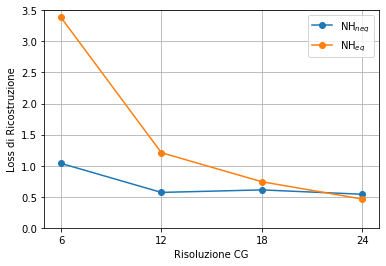

In [41]:
plt.plot(N_CG, loss_ae_CGn, 'o-', label=r'NH$_{neq}$')
plt.plot(N_CG, loss_ae_CGn2, 'o-', label=r'NH$_{eq}$')
plt.xticks(ticks=[6,  12,  18,  24])
plt.xlim(5, 25)
plt.ylim(0, 3.5)
plt.xlabel('Risoluzione CG')
plt.ylabel('Loss di Ricostruzione')
plt.grid()
plt.legend(loc='upper right')
plt.savefig('comp_noneq.png', dpi=1200)
plt.show()

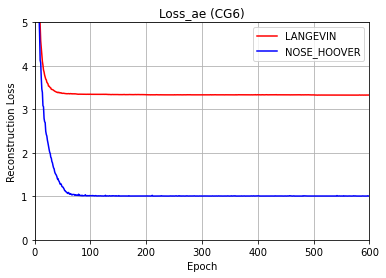

In [44]:
plt.plot(np.arange(len(loss_ae_CG6l)), loss_ae_CG6l, color='red',  label='LANGEVIN')
plt.plot(np.arange(len(loss_ae_CG6n)), loss_ae_CG6n, color='blue', label='NOSE_HOOVER_2')

plt.ylim(0, 5)
plt.xlim(0, 600)

plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')

plt.legend(loc='upper right')
plt.grid()
plt.title('Loss_ae (CG6)')

plt.savefig('Confronto_loss_ae_CG6.png', dpi=1200)
plt.show()

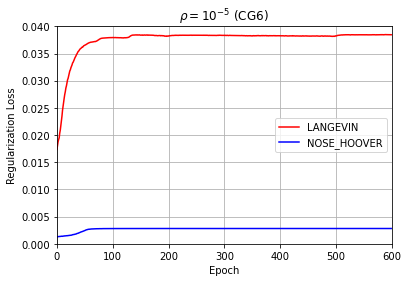

In [43]:
plt.plot(np.arange(len(loss_fm_CG6l)), loss_fm_CG6l, color='red',  label='LANGEVIN')
plt.plot(np.arange(len(loss_fm_CG6n)), loss_fm_CG6n, color='blue', label='NOSE_HOOVER')

#plt.ylim(0, 5)
plt.xlim(0, 600)
plt.ylim(0, 0.04)

plt.xlabel('Epoch')
plt.ylabel('Regularization Loss')

plt.legend(loc='center right')
plt.grid()
plt.title(r'$\rho = 10^{-5}$ (CG6)')
plt.show()

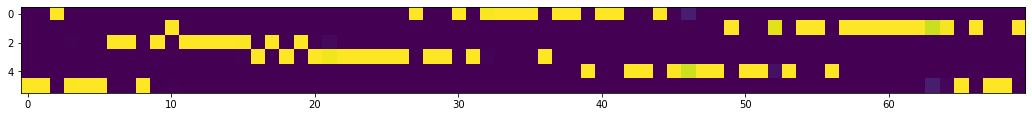

In [27]:
ML_6i = torch.load('LANGEVIN/M/M_CG6_i.pt')
ML_6f = torch.load('LANGEVIN/M/M_CG6_f.pt')
plt.figure(figsize=(18, 20))
plt.imshow(ML_6f.t().detach().cpu().numpy())

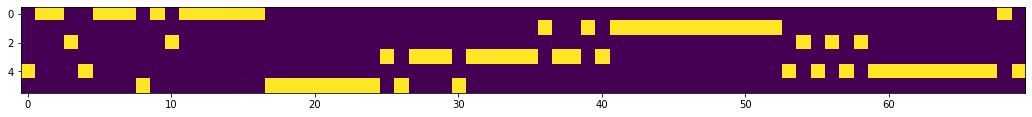

In [29]:
MNH_6i = torch.load('NOSE_HOOVER/M/M_CG6_i.pt')
MNH_6f = torch.load('NOSE_HOOVER/M/M_CG6_f.pt')
plt.figure(figsize=(18,20))
plt.imshow(MNH_6f.t().detach().cpu().numpy())

In [28]:
ML_6f = torch.load('LANGEVIN/M/M_CG6_f.pt')
ML_12f = torch.load('LANGEVIN/M/M_CG12_f.pt')
ML_18f = torch.load('LANGEVIN/M/M_CG18_f.pt')
ML_24f = torch.load('LANGEVIN/M/M_CG24_f.pt')

MNH_6f = torch.load('NOSE_HOOVER/M/M_CG6_f.pt')
MNH_12f = torch.load('NOSE_HOOVER/M/M_CG12_f.pt')
MNH_18f = torch.load('NOSE_HOOVER/M/M_CG18_f.pt')
MNH_24f = torch.load('NOSE_HOOVER/M/M_CG24_f.pt')

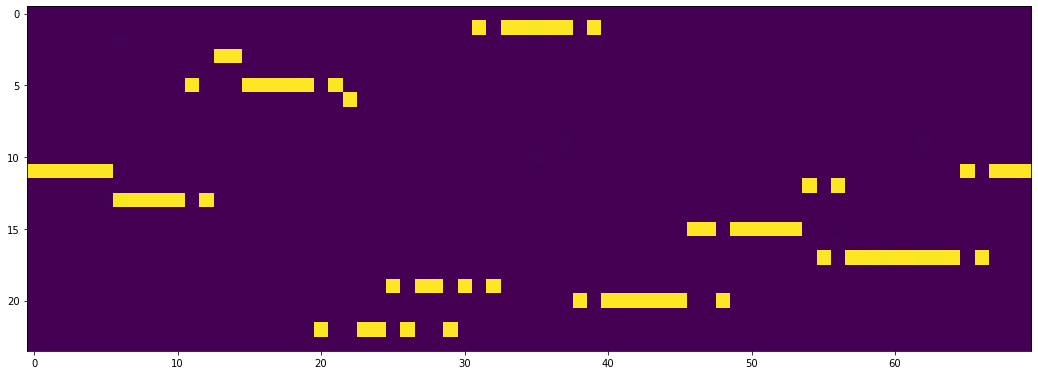

In [29]:
plt.figure(figsize=(18,20))
plt.imshow(MNH_24f.t().detach().cpu().numpy())

In [48]:
for i in np.arange(6):
    c = ML_6f[:, i] > 0.01
    print(c.sum())
            


tensor(13, device='cuda:0')
tensor(15, device='cuda:0')
tensor(11, device='cuda:0')
tensor(13, device='cuda:0')
tensor(12, device='cuda:0')
tensor(11, device='cuda:0')


In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8,8))
#fig.text(0.04, 0.5, 'Indice Siti CG', va='center', rotation= 90, fontsize='x-large', color = 'blue')
fig.text(0.97, 0.5, 'Indice Siti CG', va='center', rotation=-90, fontsize='x-large', color = 'green')

axes[0].set_title(r'NH$_{eq}$')
axes[0].plot(N_CG, loss_ae_CGn2, 'o-', label = 'Loss_ae')
#ax1.set_ylabel('Reconstruction loss')
axes[0].set_xticks(ticks=[6,  12,  18,  24])
axes[0].tick_params(axis='x', direction='in')
axes[0].grid()
axes[0].set_ylim(0, 3.5)
#axes[0].legend(loc='center left')

axes0 = axes[0].twinx()
axes0.plot(N_CG, loss_fm_CGn2/RHO_NH, 'o-', label = 'Loss_fm', color = 'green')
#ax1.set_ylabel('Reconstruction loss')
#axes0.set_xticks(ticks=[6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26])
axes0.tick_params(axis='x', direction='in')
#axes0.grid()
#axes0.legend(loc='center right')




axes[1].set_title(r'L$_{eq}$')
axes[1].plot(N_CG, loss_ae_CGl, 'o-', label = r'$Loss_{ae}$')
#ax1.set_ylabel('Reconstruction loss')
axes[1].set_xticks(ticks=[6,  12,  18,  24])
axes[1].tick_params(axis='x', direction='in')
axes[1].set_xlabel('Risoluzione CG', fontsize='x-large')
axes[1].grid()
axes[1].set_ylim(0, 3.5)
#axes[1].legend(loc='center left')

axes1 = axes[1].twinx()
axes1.plot(N_CG, loss_fm_CGl/RHO_L, 'o-', label = 'Loss_fm', color = 'green')
#ax1.set_ylabel('Reconstruction loss')
#axes0.set_xticks(ticks=[6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26])
axes1.tick_params(axis='x', direction='in')
#axes0.grid()
#axes1.legend(loc='center right')
plt.savefig('LvsNH.png', dpi=1200)
plt.show()

In [21]:
# creates: C2H4.png
from ase.build.molecule import molecule
from ase.io import write
from ase.io.pov import get_bondpairs, set_high_bondorder_pairs

In [30]:
#C70 = molecule('C70H140')


KeyError: 'C2H54'

In [32]:
C2H4 = molecule('C2H4')
r = [{'C': 0.4, 'H': 0.2}[at.symbol] for at in C2H4]
bondpairs = get_bondpairs(C2H4, radius=1.1)
high_bondorder_pairs = {}

In [34]:
# This defines offset, bond order, and bond_offset of the bond between 0 and 1
high_bondorder_pairs[(0, 1)] = ((0, 0, 0), 2, (0.17, 0.17, 0))
bondpairs = set_high_bondorder_pairs(bondpairs, high_bondorder_pairs)

renderer = write('C2H4.pov', C2H4, format='pov',
                 radii=r, rotation='90y',
                 povray_settings=dict(canvas_width=200, bondatoms=bondpairs))
#renderer.render()

In [41]:
bondpairs

[[0, 1, (0, 0, 0), 2, (0.17, 0.17, 0)],
 (0, 2, array([0, 0, 0])),
 (0, 3, array([0, 0, 0])),
 (1, 4, array([0, 0, 0])),
 (1, 5, array([0, 0, 0]))]